In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import os
from functools import partial

from tqdm import tqdm as tqdm

# wandb for plotting
import wandb

# PopGen for data loader and worker utils.
from popgen.setup import setup_loaders, setup_config
from popgen.workers.abstract_worker import AbstractWorker

from sklearn.datasets import make_s_curve, make_swiss_roll

In [2]:
X, color = make_swiss_roll(n_samples=5000, noise=0.3)
X = X / 4
X = np.stack((X[:, 0], X[:, 2]), axis=1)
x, y = X[:, 0], X[:, 1]
print(X.shape)

(5000, 2)


/home/angusturner/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

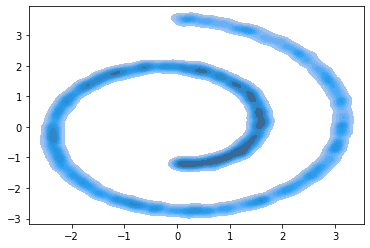

In [3]:
sns.kdeplot(x, y, fill=True, bw_adjust=0.2)

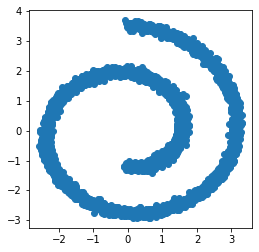

In [4]:
plt.figure(figsize=(4, 4))
plt.scatter(x, y)

In [5]:
class DiffusionProcess(nn.Module):
    def __init__(self, nb_timesteps=50, start=1e-4, end=0.05):
        super().__init__()
        
        self.nb_timesteps = nb_timesteps
        
        # beta = likelihood variance q(x_t | x_t-1)
        beta = torch.linspace(start, end, nb_timesteps)
        alpha = 1. - beta
        alpha_hat = alpha.cumprod(dim=0)
        
        # q(x_t|x_0) = N(x_t ; sqrt(alpha_hat) * x_0, forward_variance)
        prior_variance = (1. - alpha_hat)
        
        # forward process posterior variance (beta_hat) corresponding to (q(x_t-1 | x_t, x_0)
        alpha_hat_t_1 = F.pad(alpha_hat, (1, 0))[:-1]
        posterior_variance = (1 - alpha_hat_t_1) * beta / (1 - alpha_hat)
        posterior_variance[0] = beta[0]
        
        for (name, tensor) in [
            ("beta", beta),
            ("alpha", alpha),
            ("alpha_hat", alpha_hat),
            ("prior_variance", prior_variance),
            ("posterior_variance", posterior_variance)
        ]:
            self.register_buffer(name, tensor)
    
    def sample_t(self, batch_size=1, device=None):
        """
        Sample a random timestep for each batch item.
        """
        return torch.randint(0, self.nb_timesteps, size=(batch_size,), device=device)
        
    def sample_q(self, x0, eps, t):
        """
        The "forward process". Given the data point x_0, we can sample
        any latent x_t from q(x_t|x_0)
        :param x0: the initial data point (batch, *)
        :param eps: noise samples from N(0, I) (batch, *)
        :param t: the timesteps in [0, nb_timesteps] (batch)
        """
        assert (t >= 0).all() and (t < self.nb_timesteps).all(), "Invalid timestep"
        
        alpha_hat_t = self.alpha_hat[t, None] # (batch, 1, 1, 1)
        return alpha_hat_t.sqrt() * x0 + (1. - alpha_hat_t).sqrt() * eps
    
    def sample_q_next(self, x_t, eps, t):
        """
        :param x_t: previous step! (batch, *)
        :param eps: noise samples from N(0, I) (batch, *)
        :param t: the timesteps in [0, nb_timesteps] (batch)
        """
        assert (t >= 0).all() and (t < self.nb_timesteps).all(), "Invalid timestep"
        beta = self.beta[t, None]
        mu = (1. - beta).sqrt() * x_t
        return mu + (beta.sqrt() * eps)
    
    def sample_p(self, x_t, eps_hat, t, greedy=False):
        """
        The "reverse process". Given a latent `x_t`, draw a sample from p(x_t-1|x_t)
        using the noise prediction.
        :param x_t: the previous sample (batch, *)
        :param eps_hat: the noise, predicted by neural net (batch, *)
        :param t: the timestep (batch)
        """
        
        alpha_t = self.alpha[t, None, None, None] # (batch, 1, 1, 1)
        beta_t = self.beta[t, None, None, None]
        alpha_hat_t = self.alpha_hat[t, None, None, None]
        
        # calculate the mean
        mu = x_t - ((beta_t * eps_hat) / (1. - alpha_hat_t).sqrt())
        mu = (1. / alpha_t.sqrt()) * mu
        
        if greedy:
            return mu
        
        # sample
        std = self.posterior_variance[t, None, None, None].sqrt()
        x_next = mu + std * torch.randn_like(mu)
        
        return x_next

In [6]:
nb_steps = 200
start = 1e-4
end = 0.05
diff_process = DiffusionProcess(nb_steps, start, end)
print(diff_process.prior_variance[-1])
print(diff_process.prior_variance[0])

print(diff_process.posterior_variance[0])
print(diff_process.beta[0])

tensor(0.9939)
tensor(0.0001)
tensor(1.0000e-04)
tensor(1.0000e-04)


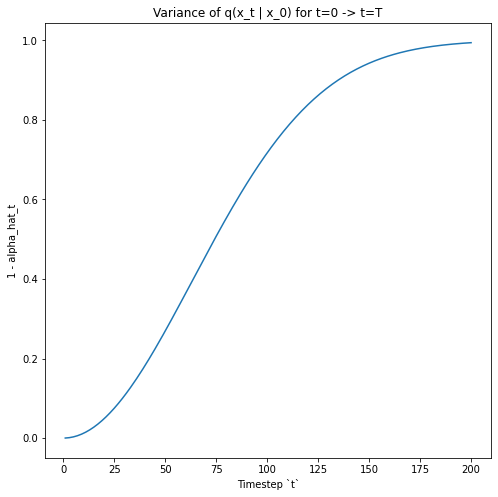

In [7]:
# visualise the various terms
t = torch.arange(1, nb_steps+1)
plt.figure(figsize=(8, 8))
plt.title("Variance of q(x_t | x_0) for t=0 -> t=T")
plt.xlabel("Timestep `t`")
plt.ylabel("1 - alpha_hat_t")
plt.plot(t[:], diff_process.prior_variance[:])
plt.show()

In [8]:
with torch.no_grad():
    x0 = torch.tensor(X).float()
    x_t = x0
    out = [x0]
    batch = x0.shape[0]
    for t in tqdm(range(1, nb_steps)):
        t_ = torch.full((batch,), t, dtype=torch.long, device=x0.device)
        eps = torch.randn_like(x0)
#         x_t = diff_process.sample_q(x0, eps, t_)
        x_t = diff_process.sample_q_next(x_t, eps, t_)
        out.append(x_t.cpu())

100%|██████████| 199/199 [00:00<00:00, 4911.25it/s]


/home/angusturner/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


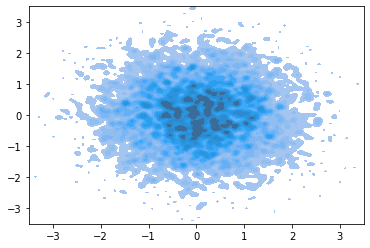

In [9]:
# plot the final step
x, y = out[-1][:, 0], out[-1][:, 1]
fig, ax = plt.subplots()
# ax.scatter(x, y)
sns.kdeplot(x, y, fill=True, ax=ax, bw_adjust=0.2)
ax.set_xlim(-3.5, 3.5)
ax.set_ylim(-3.5, 3.5)
plt.show()

# ax.set_xlim(-3, 3)
# plt.scatter(x, y)
# # plt.contour(out[-1])
# sns.kdeplot(x, y, fill=True)

In [10]:
import os

def plot_density(x, y, i=0, out_dir='pngs'):
    fig, ax = plt.subplots()
#     ax.scatter(x, y)
    sns.kdeplot(x=x, y=y, fill=True, ax=ax, bw_adjust=0.2)
    ax.set_xlim(-3.5, 3.5)
    ax.set_ylim(-3.5, 3.5)
    i_str = "{}".format(i).zfill(3)
    out_path = os.path.join(out_dir, f"fig_{i_str}.png")
    plt.savefig(out_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

In [11]:
for i in tqdm(range(0, nb_steps)):
    x, y = out[i][:, 0], out[i][:, 1]
    plot_density(x, y, i)

100%|██████████| 200/200 [06:58<00:00,  2.09s/it]


In [29]:
torch.randint(0, 1, size=(1,))

tensor([0])